Fenn Xiao (Kaifeng Xiao 肖凯峰)

College of Computer Science and Technology, Huaqiao University 华侨大学计算机科学与技术学院

**Keywords** *NLP, Social Media, Sentiment Analysis, Public Opinion, Text Mining, Machine Learning*

# Introduction

In the digital age, social media platforms, with Twitter *(now known as "X", but still referred to as "Twitter")* as a prime example, have emerged as a rich source of data for sentiment analysis, playing a pivotal role in both shaping and reflecting public opinion. 
Natural Language Processing *(NLP)*, an indispensable tool in the arsenal of data science research, has made significant strides in various applications, among which sentiment analysis stands out as one of the most prevalent.


This essay endeavors to explore into the principles and practical applications of NLP by solving the practical challenge of Twitter sentiment analysis.

This research has been given the problem of detecting hate and unfriendly speech in tweets published by Twitter to infer social media sentiment trends. Specifically, given a training sample of labelled Tweets, where ‘Positive’ indicates that the Tweet contains a positive emotional attitude, ‘Irrelevant’ indicates neutrality, and ‘Negative’ indicates that it contains negative, hateful, or unfriendly remarks, such as racist, sexist, etc.

The objective is to develop a model capable of accurately predicting sentiment categories in a validation dataset. In terms of evaluation metrics, while several options are available, this research will prioritize the F1-Score for its effectiveness in balancing precision and recall in classification tasks.

# First Step: Tweets Data Preprocessing & Cleaning

Pre-processing of text data is an essential first step in the NLP exploration process, which can help to extract effective information in the vast amount of text data.

As shown by some of the tweets in the training and test sets, many of the tweets contain content that is irrelevant for analysing sentiment, such as user names, punctuation marks, special characters and numbers. After loading and reading the data, the data should be cleaned.

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings

# OPTIONAL
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
# pd.set_option('max_colwidth',1000)

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
%matplotlib inline

column_names = ['id', 'keyword', 'sentiment', 'tweet']
train = pd.read_csv('data/twitter_training.csv', names=column_names)
test = pd.read_csv('data/twitter_validation.csv', names=column_names)

train.head(10)

,id,keyword,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


The data consists of 4 columns and the columns we need to focus on are the last two columns, which are ‘Sentiment’ and ‘Tweet’.

- **Sentiment:** the tag used to indicate the sentiment of the Tweet, including ‘Positive’, ‘Irrelevant’ and ‘Negative’.
- **Tweets:** the content of the tweet.

Although in the header of the dataset we don't seem to see some extraneous information that needs to be cleared, such as usernames, links or hashtags, etc., these are still present after a full-text lookup of the dataset file.

## Removing Unnecessary Components of Tweet's Content

Therefore, a method called `remove_pattern` is implemented here to match and remove the specified content from the text data using regular expressions.

Incidentally, we merge the training and validation sets to reduce repetitive operations, which is no different in the final result than separating the two datasets.

In [3]:
datasets = pd.concat([train, test], ignore_index=True)
datasets['tweet'] = datasets['tweet'].astype(str)

In [4]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

Now, we can use the `remove_pattern` method to clean up handles, special characters, numbers and so on in tweets, which brings up a brand new column called `cleaned_tweet`.

In [5]:
# remove twitter handles (@user)
datasets['cleaned_tweet'] = np.vectorize(remove_pattern)(datasets['tweet'], "@[\w]*")

In [6]:
# remove URL links
datasets['cleaned_tweet'] = np.vectorize(remove_pattern)(datasets['cleaned_tweet'], r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
datasets['cleaned_tweet'] = np.vectorize(remove_pattern)(datasets['cleaned_tweet'], r'(pic\.twitter\.com|dfr\.it|dlvr\.it|youtu.be)/[\w.-/]+')
datasets['cleaned_tweet'] = np.vectorize(remove_pattern)(datasets['cleaned_tweet'], r'/[\w.-/]+')

In [7]:
# remove special characters, numbers, punctuations
datasets['cleaned_tweet'] = datasets['cleaned_tweet'].str.replace("[^a-zA-Z#]", " ")

In [8]:
# remove short words
datasets['cleaned_tweet'] = datasets['cleaned_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
 
datasets.head(10)

,id,keyword,sentiment,tweet,cleaned_tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderlands will murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,"coming borders will kill all,"
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,"getting borderlands will kill all,"
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,"coming borderlands will murder all,"
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,"getting borderlands will murder all,"
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,"getting into borderlands murder all,"
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something fun. don't know H...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,spent couple hours doing something fun... don'...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,spent hours doing something fun... don't know ...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...,spent hours making something fun. don't know H...


Here we can clearly see that the contents of the `cleaned_tweet` column are stripped of extraneous pronouns, punctuation, and other information, which is convenient for our subsequent work although there is still room for optimisation.

## Tokenization and Stemming

To make it easier to turn text strings into computer-recognisable word units that contain more potential emotional information, it is needed to tokenise and stem the initially cleaned tweet data.

Here, `PortalStemmer` in Natural Language Toolkit *(NLTK)* is used to stem the tokenised data, while `word_tokenize` is used to tokenise the original words. We will use these data later in the `Word Embedding: Word2Vec` section.

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from nltk.stem.porter import *
stemmer = PorterStemmer()

# Tokenization, Removing Stopwords, and Stemming
def preprocess_text(text):
    tokens = word_tokenize(text.lower())

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return stemmed_tokens

datasets['processed_tokens'] = datasets['cleaned_tweet'].apply(preprocess_text)
print(datasets['processed_tokens'].head())

0     [get, borderland, murder]
1          [come, border, kill]
2       [get, borderland, kill]
3    [come, borderland, murder]
4     [get, borderland, murder]
Name: processed_tokens, dtype: object


At this point, we can tell that we have completed the initial process of cleaning and pre-processing the tweet data.

## WordCloud

Using `wordcloud` to generate word cloud maps of cleaned Tweet content.

In [10]:
from wordcloud import WordCloud

def generate_wordcloud(words_pattern):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words_pattern)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

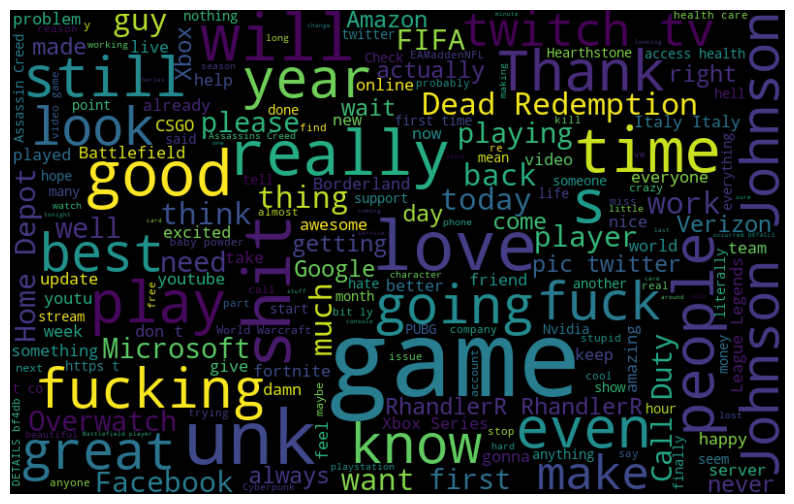

In [11]:
all_words = ' '.join([text for text in datasets['cleaned_tweet']])
generate_wordcloud(all_words)

### Normal Tweets WordCloud

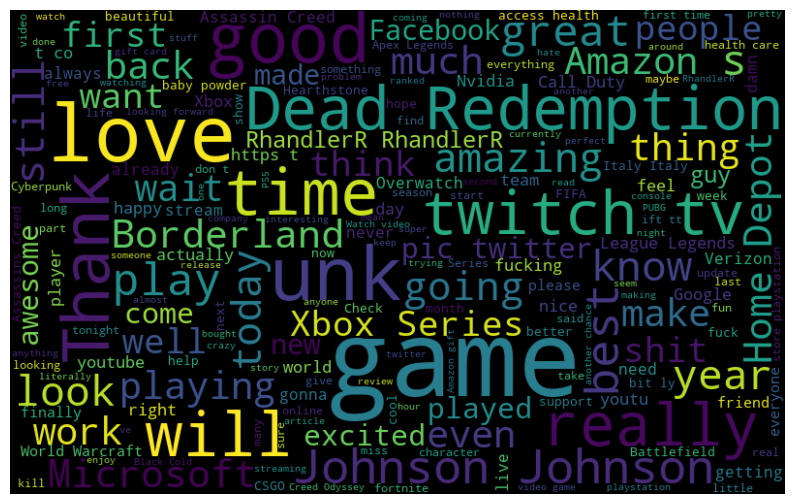

In [12]:
normal_words = ' '.join([text for text in datasets['cleaned_tweet'][
    (datasets['sentiment'] == 'Positive') | (datasets['sentiment'] == 'Neutral')
]])
 
generate_wordcloud(normal_words)

### Negative Tweets WordCloud

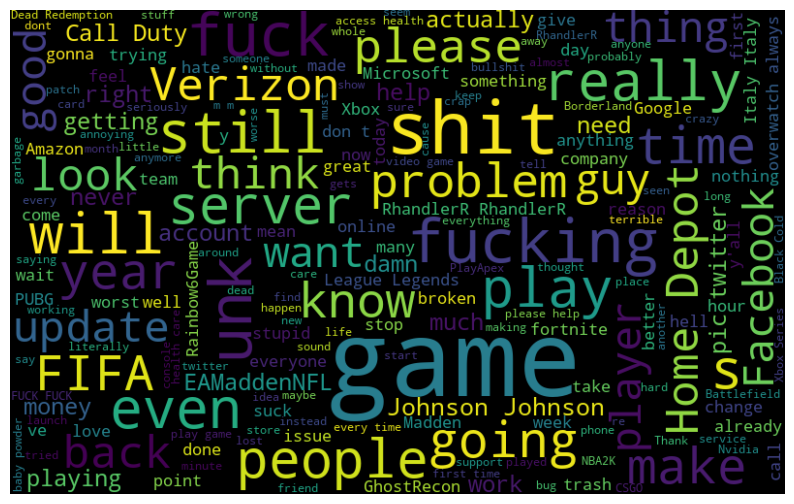

In [13]:
negative_words = ' '.join([text for text in datasets['cleaned_tweet'][datasets['sentiment'] == 'Negative']])
generate_wordcloud(negative_words)


### Irrelevant Tweets WordCloud

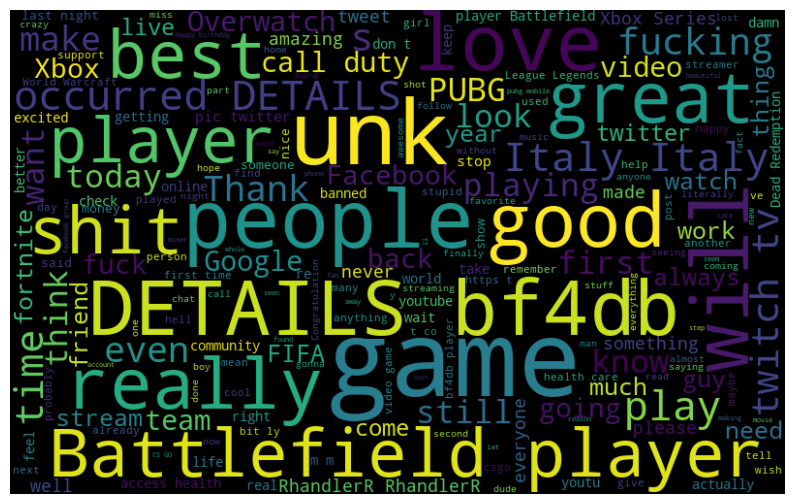

In [14]:
irrelevant_words = ' '.join([text for text in datasets['cleaned_tweet'][datasets['sentiment'] == 'Irrelevant']])
generate_wordcloud(irrelevant_words)

# Model Building, Training and Validating: 3 Different Ways

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
datasets['sentiment_encoded'] = le.fit_transform(datasets['sentiment'])

## Word Embedding: Word2Vec

Since we have already done Tokenisation and Stemming on the text data in the previous preprocessing session, we can now train our own `Word2Vec` model and make predictions on the validation set.

In this section, we define a class called `EpochLogger` to watch the whole process of Word2Vec model training. Usually it can be quick, however if the progress is slower than usual, the parameters can be adjusted for efficiency.

In [16]:
# Defining a callback func to watch the whole process
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''
    def __init__(self):
        self.epoch = 0
        
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print(f"Epoch #{self.epoch} | Loss: {loss}")
        self.epoch += 1

# Training Paras
epochs = 10
vector_size = 100
window_size = 5
min_count = 1
workers = 6  # Adjust according to CPU cores

# Training Word2Vec Model
word2vec_model = Word2Vec(
    sentences=datasets['processed_tokens'],
    vector_size=vector_size,
    window=window_size,
    min_count=min_count,
    workers=workers,
    epochs=epochs,
    callbacks=[EpochLogger()]
)

# Save Model
word2vec_model.save("word2vec_model.bin")

Epoch #0 | Loss: 0.0
Epoch #1 | Loss: 0.0
Epoch #2 | Loss: 0.0
Epoch #3 | Loss: 0.0
Epoch #4 | Loss: 0.0
Epoch #5 | Loss: 0.0
Epoch #6 | Loss: 0.0
Epoch #7 | Loss: 0.0
Epoch #8 | Loss: 0.0
Epoch #9 | Loss: 0.0


Loading Word2Vec model and using a function called `text_to_vector` to transform the token texts into vector means.

In [17]:
# Loading Word2Vec Model
word2vec_model = Word2Vec.load("word2vec_model.bin")

def text_to_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv.key_to_index]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Converting Token Texts to Vector Means
datasets['vector'] = datasets['processed_tokens'].apply(lambda tokens: text_to_vector(tokens, word2vec_model))

It's time to train and gain! Converting vectors into NumPy arrays, splitting the train and test sets, and then using LogisticRegression to fit and train the Word2Vec Model in order to get the predictions.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Converting Vectors into NumPy arrays
X = np.vstack(datasets['vector'].values)
y = datasets['sentiment_encoded']

train_word2vec = X[:74682, :]
test_word2vec = X[74682:, :]

X_train, X_test, y_train, y_test = train_test_split(train_word2vec, datasets[:74682]['sentiment_encoded'], test_size=0.2, random_state=42)

lreg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100000)
lreg.fit(X_train, y_train)

predictions = lreg.predict(X_test)

print(classification_report(y_test, predictions, target_names=['Irrelevant', 'Positive', 'Neutral', 'Negative']))

/Users/fenn/opt/anaconda3/envs/twiSentimentAnalysis/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

  Irrelevant       0.42      0.16      0.23      2592
    Positive       0.56      0.66      0.60      4519
     Neutral       0.43      0.49      0.46      3596
    Negative       0.54      0.58      0.56      4230

    accuracy                           0.51     14937
   macro avg       0.49      0.47      0.46     14937
weighted avg       0.50      0.51      0.49     14937



The macro-averaged F1 score is 0.46, while the weighted average F1 score is 0.49, which suggests that this model performs moderately well in predictive analytics for the multi-classification problem of analysing the sentiment of tweets, but there is still room for improvement.

## Bag-of-Words

Bag-of-Words is a method to represent text into numerical features. Bag-of-Words features can be easily created using sklearn’s `CountVectorizer` function. We will set the parameter max_features = 5000 to select only top 5000 terms ordered by term frequency across the corpus. We have already tried 1k, 2k and 5k for the parameter to get the better effects.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(datasets['cleaned_tweet'])

Splitting the train and test sets, then using LogisticRegression to fit and train the Bag-of-Words Model in order to get the predictions.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
 
train_bow = bow[:74682,:]
test_bow = bow[74682:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['sentiment'], random_state=42, test_size=0.3)

lreg = LogisticRegression(solver='saga', max_iter=100000)
lreg.fit(xtrain_bow, ytrain) # training the model
 
predictions = lreg.predict(xvalid_bow) # predicting on the validation set
print(classification_report(yvalid, predictions, target_names=['Irrelevant', 'Positive', 'Neutral', 'Negative']))


              precision    recall  f1-score   support

  Irrelevant       0.66      0.52      0.58      3870
    Positive       0.66      0.80      0.72      6739
     Neutral       0.70      0.61      0.65      5424
    Negative       0.69      0.70      0.70      6372

    accuracy                           0.68     22405
   macro avg       0.68      0.66      0.66     22405
weighted avg       0.68      0.68      0.67     22405



In [21]:
print(confusion_matrix(yvalid, predictions))

[[1996  775  392  707]
 [ 303 5367  486  583]
 [ 355 1010 3331  728]
 [ 368  951  563 4490]]


In [22]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred.argmax(axis=1)
test['sentiment'] = le.inverse_transform(test_pred_int)
saving = test[['id','sentiment']]
saving.to_csv('result_bow.csv', index=False) # writing data to a CSV file

saving.head(10)

,id,sentiment
0,3364,Irrelevant
1,352,Neutral
2,8312,Irrelevant
3,4371,Negative
4,4433,Neutral
5,6273,Negative
6,7925,Positive
7,11332,Positive
8,1107,Positive
9,2069,Negative


The macro-averaged F1 score is 0.66, while the weighted average F1 score is 0.67, which suggests that this model is about a third better at predictively analysing tweets for this multi-classification problem than the previous one, but it cannot be ruled out that this is a model training difference.

## TF-IDF

`TF-IDF` is another approach based on word frequency, but unlike the `bag-of-words` approach, it takes into account not only the number of occurrences of a word in a single document (or tweet), but also the occurrences of the word in the corpus as a whole.

It works by assigning common words lower weights, while giving weight to words that are rare in the whole corpus but have a high number of occurrences in a few documents (i.e., assigning higher weights).

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=5000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(datasets['cleaned_tweet'])


In [24]:
train_tfidf = tfidf[:74682,:]
test_tfidf = tfidf[74682:,:]
 
xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]
 
lreg.fit(xtrain_tfidf, ytrain)

predictions = lreg.predict(xvalid_tfidf) # predicting on the validation set
print(classification_report(yvalid, predictions, target_names=['Irrelevant', 'Positive', 'Neutral', 'Negative']))


              precision    recall  f1-score   support

  Irrelevant       0.66      0.49      0.56      3870
    Positive       0.65      0.80      0.72      6739
     Neutral       0.67      0.61      0.64      5424
    Negative       0.70      0.69      0.69      6372

    accuracy                           0.67     22405
   macro avg       0.67      0.65      0.65     22405
weighted avg       0.67      0.67      0.67     22405



In [25]:
print(confusion_matrix(yvalid, predictions))

[[1877  840  449  704]
 [ 285 5393  527  534]
 [ 337 1070 3320  697]
 [ 325 1001  635 4411]]


In [26]:
test_pred = lreg.predict_proba(test_tfidf)
test_pred_int = test_pred.argmax(axis=1)
test['sentiment'] = le.inverse_transform(test_pred_int)
saving = test[['id','sentiment']]
saving.to_csv('result_tfidf.csv', index=False) # writing data to a CSV file

saving.head(10)

,id,sentiment
0,3364,Irrelevant
1,352,Neutral
2,8312,Negative
3,4371,Negative
4,4433,Neutral
5,6273,Negative
6,7925,Positive
7,11332,Irrelevant
8,1107,Positive
9,2069,Negative


The macro-averaged F1 score is 0.65, while the weighted average F1 score is 0.67, which suggests that this model is nearly as same as the Bag-of-Words model at predictively analysing tweets for this multi-classification problem.

# Conclusion

In minimising the differences brought about by the pre-processing process and model training, this study shows the relative advantages of `bag-of-words` and `TF-IDF` over `word embedding` (`Word2Vec`) in the exploration of Twitter sentiment analysis, a real-world NLP problem.


This may be due to the following reasons:

- **Context Sensitivity:** The context-sensitivity of embedding models can capture subtle differences in the meaning of words across different contexts, which is very useful for complex natural language processing tasks. However, in some specific tasks, contextual information may not be the most critical factor, and TF-IDF or BoW models may better reflect the frequency information of terms, which can be more helpful in certain scenarios.

- **High Feature Dimensionality Demand:** Embedding models typically have a high dimensionality (e.g., 300 dimensions), which can lead to higher computational costs and overfitting in feature spaces with large dimensions. In contrast, TF-IDF or BoW models have lower dimensions and a more compact feature space, which may perform better on some datasets.

- **Task Characteristics:** Different NLP tasks have different requirements for models. For example, in sentiment analysis tasks, the importance of sentiment words may be higher, and TF-IDF can capture this well; while in named entity recognition tasks, the semantic relationships between words are more important, and embedding models may perform better.

In sentiment analysis tasks, which text representation to choose depends on several factors, including the amount of data, the importance of the context, and computational resources. If the data volume is large enough and contextual information is important, word embedding may be the best choice. If the data volume is small or context information is not a key factor, BoW or TF-IDF may be more appropriate.

In practice, it is also possible to try datasetsning multiple approaches, such as using word embeddings in conjunction with TF-IDF or BoW models, in order to make full use of their respective advantages. In addition, for some tasks, more advanced context-sensitive word embedding models such as BERT or RoBERTa can be considered, which are able to capture the changes of words in different contexts to a greater extent.

visit: [Github:fennland/PBL-NLP-Twitter-Sentiment-Analysis](https://github.com/fennland/pbl-nlp-twitter-sentiment-analysis)